In [1]:
#change model lat space from tp 0-360

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import pickle

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44587/status,
Dashboard: /proxy/44587/status,Workers: 8
Total threads: 8,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46839,Workers: 8
Dashboard: /proxy/44587/status,Total threads: 8
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://10.6.132.1:33087,Total threads: 1
Dashboard: /proxy/43597/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:34965,


In [6]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

In [7]:
#cc.querying.get_experiments(session)

In [8]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [30]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1)
ht.load()
print(ht.shape)

variable='hu'
hu = cc.querying.getvar(expt,variable,session, n=-1)
hu.load()
print(hu.shape)

(2700, 3600)
(2700, 3600)


In [31]:
hu

<xarray.DataArray 'hu' (yu_ocean: 2700, xu_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

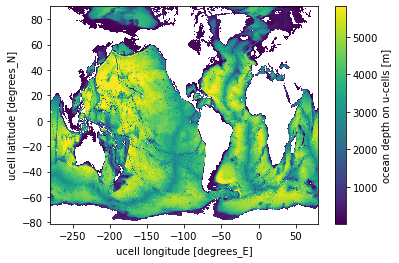

In [32]:
hu.plot.pcolormesh()

In [33]:
def change_lon_space(ds, grid):
    if grid == 'u':
        #ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xu_ocean'] < 0, ds['xu_ocean'] + 360, ds['xu_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])

        ds = ds.swap_dims({'xu_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xu_ocean')
        ds = ds.rename({'_lon_adj': 'xu_ocean'})
    elif grid == 't':
        #ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xt_ocean'] < 0, ds['xt_ocean'] + 360, ds['xt_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])
        
        ds = ds.swap_dims({'xt_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xt_ocean')
        ds = ds.rename({'_lon_adj': 'xt_ocean'})
    return ds

In [34]:
hu = change_lon_space(hu, 'u')
hu

<xarray.DataArray 'hu' (yu_ocean: 2700, xu_ocean: 3600)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [3189.2727, 3158.8103, 3102.7876, ..., 3250.681 , 3235.3816,
        3216.1902],
       [3231.6184, 3213.3965, 3176.3525, ..., 3233.1042, 3268.9646,
        3253.4143],
       [2909.8333, 2805.8433, 2781.0015, ..., 2985.7146, 3086.1804,
        3009.3606]], dtype=float32)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
  * xu_ocean  (xu_ocean) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

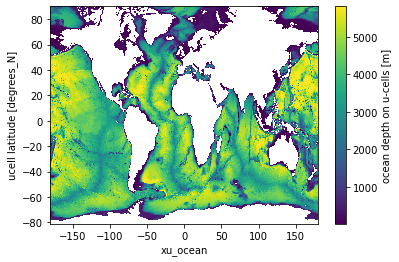

In [35]:
hu.plot.pcolormesh()

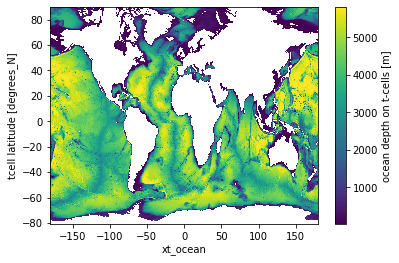

In [36]:
ht = change_lon_space(ht, 't')
ht.plot.pcolormesh()